### TEMA

Debido a la gran variedad de vídeos que nos ofrecen las distintas plataformas, conocer por qué algunos vídeos triunfan y otros no, es todo un desafío. Por eso, este proyecto se centra en analizar la **influencia de las características de los títulos de los videos de 5-Minute Crafts en el número total de visualizaciones** que reciben. De esta manera, prodemos intentar **predecir la popularidad de los vídeos** usando Machine Learning.

5-Minute Crafts es un canal de YouTube conocido por sus videos de estilo "Do It Yourself (DIY)" y es uno de los canales más populares en la plataforma. A pesar del éxito del canal, este también ha sido muy polémico por proponer algunos trucos peligrosos y, además, hacer mucho uso de clickbait en sus vídeos. Es decir, seleccionan títulos sensacionalistas y engañosos para llamar la atención de las personas.

Para poder hacer mi proyecto, utilizaré el mismo dataset que utilicé para mi EDA: https://www.kaggle.com/datasets/shivamb/5minute-crafts-video-views-dataset/data


# MODELANDO EL ÉXITO VIRAL: PREDICCIÓN DE LA POPULARIDAD DE LOS VÍDEOS DE 5-MINUTE CRAFTS

# Importar librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import joblib
from joblib import dump

2024-03-12 17:00:38.482975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Impotar datos

In [3]:
five_minute_crafts = pd.read_csv('/content/5-Minute Crafts.csv')

In [4]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000


# EDA

### Notas con información de algunas columnas

* Active_since_days: vídeo activo desde x días
* Num_chars: caracteres totales del título del vídeo
* Num_words: total de palabras en el título del vídeo
* Num_punctuation: número de signos de puntuación
* Num_words_uppercase: número de palabras en mayúscula
* Num_words_lowercase: número de palabras en minúscula
* Num_stopwords: "palabras vacías".Son palabras que para la recuperación de información y en el procesamiento del lenguaje natural debido a que no aporta un significado específico y no ayuda a distinguir un documento o fragmento de texto particular. Estas palabras suelen ser preposiciones, conjunciones, artículos y otros términos muy frecuentes en un idioma. Ejem: the, and,is,in,of...
* Avg_word_len: longitud media de la palabra
* Contain_digits: el título contiene dígitos
* Startswith_digits: si el título empieza por un dígito
* Title_sentiment: sentimiento del título del vídeo.  Significa lo positivo o negativo que es el título. Se calcula con la biblioteca textblob de python

In [5]:
five_minute_crafts.dtypes

video_id                object
title                   object
active_since_days        int64
duration_seconds         int64
total_views              int64
num_chars                int64
num_words                int64
num_punctuation          int64
num_words_uppercase      int64
num_words_lowercase      int64
num_stopwords            int64
avg_word_len           float64
contain_digits           int64
startswith_digits        int64
title_sentiment        float64
dtype: object

In [6]:
five_minute_crafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             4978 non-null   object 
 1   title                4978 non-null   object 
 2   active_since_days    4978 non-null   int64  
 3   duration_seconds     4978 non-null   int64  
 4   total_views          4978 non-null   int64  
 5   num_chars            4978 non-null   int64  
 6   num_words            4978 non-null   int64  
 7   num_punctuation      4978 non-null   int64  
 8   num_words_uppercase  4978 non-null   int64  
 9   num_words_lowercase  4978 non-null   int64  
 10  num_stopwords        4978 non-null   int64  
 11  avg_word_len         4978 non-null   float64
 12  contain_digits       4978 non-null   int64  
 13  startswith_digits    4978 non-null   int64  
 14  title_sentiment      4978 non-null   float64
dtypes: float64(2), int64(11), object(2)
me

In [7]:
five_minute_crafts.describe()

,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
count,4978.000000,4978.000000,4.978000e+03,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000,4978.000000
mean,827.808759,932.421655,4.349619e+06,44.456408,8.208718,0.495982,6.138610,0.287264,2.050020,5.463782,0.913821,0.856770,0.225993
std,426.975866,727.392576,9.936944e+06,13.470281,2.516098,0.901010,2.546744,1.355098,1.373312,0.662885,0.280657,0.350343,0.377586
min,1.000000,11.000000,4.034000e+03,11.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.666667,0.000000,0.000000,-1.000000
25%,365.000000,696.000000,5.679352e+05,35.000000,6.000000,0.000000,5.000000,0.000000,1.000000,5.000000,1.000000,1.000000,0.000000
50%,730.000000,867.000000,1.459397e+06,43.000000,8.000000,0.000000,6.000000,0.000000,2.000000,5.375000,1.000000,1.000000,0.200000
75%,1095.000000,960.000000,4.271779e+06,52.000000,10.000000,1.000000,8.000000,0.000000,3.000000,5.800000,1.000000,1.000000,0.450000
max,1460.000000,14880.000000,2.830311e+08,100.000000,20.000000,6.000000,18.000000,12.000000,9.000000,10.000000,1.000000,1.000000,1.000000


In [8]:
five_minute_crafts.shape

(4978, 15)

In [9]:
five_minute_crafts.columns

Index(['video_id', 'title', 'active_since_days', 'duration_seconds',
       'total_views', 'num_chars', 'num_words', 'num_punctuation',
       'num_words_uppercase', 'num_words_lowercase', 'num_stopwords',
       'avg_word_len', 'contain_digits', 'startswith_digits',
       'title_sentiment'],
      dtype='object')

### Limpieza

In [10]:
five_minute_crafts.nunique()

video_id               4978
title                  4965
active_since_days        31
duration_seconds        663
total_views            4978
num_chars                87
num_words                18
num_punctuation           7
num_words_uppercase      17
num_words_lowercase      13
num_stopwords            10
avg_word_len            254
contain_digits            2
startswith_digits         2
title_sentiment         339
dtype: int64

In [11]:
nulls = five_minute_crafts.isnull().sum()
nulls

video_id               0
title                  0
active_since_days      0
duration_seconds       0
total_views            0
num_chars              0
num_words              0
num_punctuation        0
num_words_uppercase    0
num_words_lowercase    0
num_stopwords          0
avg_word_len           0
contain_digits         0
startswith_digits      0
title_sentiment        0
dtype: int64

In [12]:
duplicated = five_minute_crafts.duplicated()
total_duplicated = duplicated.sum()
total_duplicated

0

### Reemplazar ' l ' por ' | ' y volver a contar las minúsculas

In [13]:
five_minute_crafts['title'] = five_minute_crafts['title'].replace(' l ', ' | ')

In [14]:
def contar_minusculas(texto):
    return sum(1 for palabra in texto.split() if palabra[0].islower())

In [15]:
five_minute_crafts['num_words_lowercase'] = five_minute_crafts['title'].apply(contar_minusculas)

In [16]:
five_minute_crafts.to_csv('clean_five_minute_crafts.csv',index=False)

### Estudio de la correlación

In [17]:
five_minute_crafts = pd.read_csv('clean_five_minute_crafts.csv')

<Axes: >

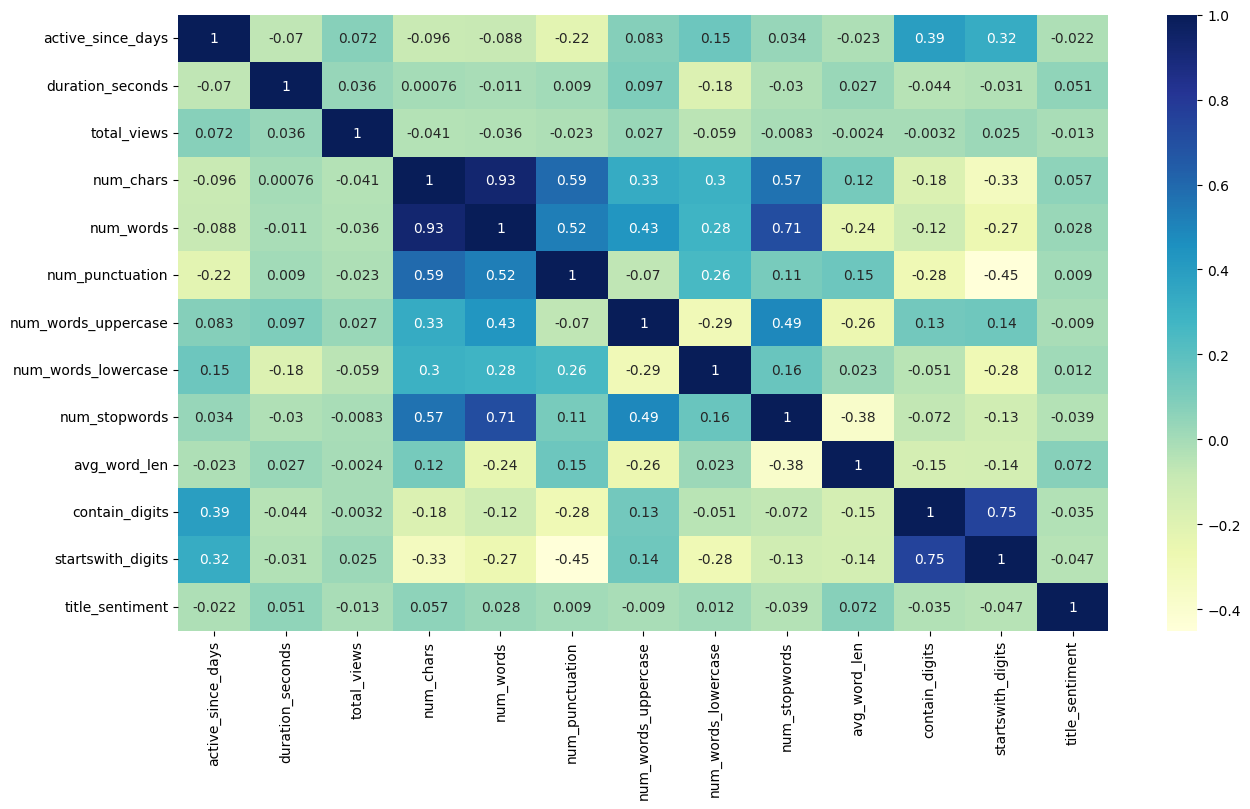

In [18]:
corr = five_minute_crafts.drop(['video_id', 'title'], axis=1).corr()

plt.figure(figsize=(15, 8))
sb.heatmap(corr, annot=True, cmap='YlGnBu')

En un principio mi idea era intentar predecir la popularidad de los vídeos usando como target la variable 'total_views'. Sin embargo, la mayoría de las características tienen **correlaciones muy bajas con 'total_views'**. Esto sugiere que no hay una relación lineal fuerte entre estas características y el número de visitas totales.

Algunas correlaciones positivas:
* 'num_chars' y 'num_words' tienen una correlación positiva moderada con 'total_views', esto podría indicar que vídeos con descripciones más largas tienden a tener más visitas, aunque la relación no es fuerte.
* 'contain_digits' y 'startswith_digits' tienen una correlación positiva leve con 'total_views', esto podría sugerir que los títulos que contienen números pueden estar asociados con un mayor número de vistas, posiblemente porque los números pueden resaltar elementos cuantitativos o listas que podrían ser atractivos para los espectadores.

Como la correlación con la target es muy baja ('total_views') necesito encontrar más variables. Para ello, voy a usar un método que ya usé en el EDA que te ayudaba a a detectar las palabras más populares/repetidas en los títulos:

In [19]:
# Tokenizar los títulos usando split() y contar la frecuencia de cada palabra:
# split(): divide una cadena en una lista de subcadenas
# Si no usas expand=True, te devolvería una serie de lista en vez de un df donde cada palabra de un título ocupa una columna diferente.
# stack(): apila las columnas del df en una sola columna para que puedan ser sumadas
frecuencia_de_palabra= five_minute_crafts['title'].str.split(expand=True).stack().value_counts()

# Obtener las 20 palabras más comunes
top_20_words = frecuencia_de_palabra.head(20)

# Imprimir las 20 palabras más comunes
print(top_20_words)

HACKS     2204
TO        1170
YOU        961
YOUR       862
AND        849
LIFE       791
FOR        745
THAT       629
||         552
IDEAS      528
25         426
DIY        424
CRAFTS     409
TRICKS     372
MAKE       369
WILL       359
EASY       325
20         324
COOL       286
30         280
dtype: int64


Voy a utilizar las 5 palabras más populares/repetidas en los títulos porque son las que mejor trabajan con el modelo. Previamente probé diferentes palabras y este número es el que mejores resultados me ha dado

In [20]:
most_popular_words = ['hacks', 'life', 'ideas','DIY', 'crafts']

# Crear una columna
five_minute_crafts['most_popular_words'] = five_minute_crafts['title'].str.lower()

dummies = pd.get_dummies(five_minute_crafts['most_popular_words'].apply(lambda x: pd.Series([1 if palabra in x else 0 for palabra in most_popular_words], index=most_popular_words)))
five_minute_crafts = pd.concat([five_minute_crafts, dummies], axis=1)

# Eliminar la columna 'most_popular_words'
five_minute_crafts.drop('most_popular_words', axis=1, inplace=True)


five_minute_crafts.head()


,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,hacks,life,ideas,DIY,crafts
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444,1,1,0,0,0
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905,1,0,1,0,0
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000,1,1,0,0,0
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333,1,0,0,0,0
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000,1,0,0,0,1


# Modelos supervisados

Comienzo probado algunos modelos supervisados de regresión:

#### Dividir los datos

In [21]:
X = five_minute_crafts.drop(['video_id', 'title', 'total_views'], axis=1)
y = five_minute_crafts['total_views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Escalar los datos

In [22]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Probar modelos

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "SVR": SVR()
}

#### Entrenar modelos

In [24]:
for name, model in models.items():
    print(f"Model: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test, y_pred)
    print("MAE:", mae)

    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

    try:
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print("MAPE:", mape)
    except ValueError:
        print("MAPE: Not calculable (may contain zeros in the test set)")

    try:
        msle = mean_squared_log_error(y_test, y_pred)
        print("MSLE:", msle)
    except ValueError:
        print("MSLE: Not calculable (may contain negative predictions)")

    print("-" * 40)

Model: Linear Regression
MSE: 146455225086340.75
RMSE: 12101868.660927566
MAE: 4805241.741330234
R²: 0.019775614836083144
MAPE: 6.755044638446344
MSLE: 2.9972365138885224
----------------------------------------
Model: Ridge Regression
MSE: 146439766796705.94
RMSE: 12101229.970408212
MAE: 4803857.054804936
R²: 0.019879077122553657
MAPE: 6.757480139957096
MSLE: 2.997465539455025
----------------------------------------
Model: Lasso Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+15, tolerance: 3.425e+13
  model = cd_fast.enet_coordinate_descent(


MSE: 146455204491922.28
RMSE: 12101867.810049914
MAE: 4805239.933570009
R²: 0.01977575267446463
MAPE: 6.755051814714295
MSLE: 2.997237722446156
----------------------------------------
Model: Elastic Net
MSE: 146980218966407.1
RMSE: 12123539.869460862
MAE: 4803609.337525326
R²: 0.016261832360930928
MAPE: 7.503685997272094
MSLE: 3.0919105286639503
----------------------------------------
Model: Random Forest Regressor
MSE: 155667785213245.6
RMSE: 12476689.673677294
MAE: 5119564.879241155
R²: -0.04188402264600177
MAPE: 4.648592479233615
MSLE: 2.512989797477735
----------------------------------------
Model: Gradient Boosting Regressor
MSE: 147251877917531.7
RMSE: 12134738.477508763
MAE: 4625681.502900176
R²: 0.014443619810416641
MAPE: 5.7059532260578525
MSLE: Not calculable (may contain negative predictions)
----------------------------------------
Model: XGBoost Regressor
MSE: 182945230360874.38
RMSE: 13525724.762868509
MAE: 5450851.070745874
R²: -0.22445188175047437
MAPE: 5.79811741918

* MSE (Mean Squared Error): Un valor más bajo indica un mejor ajuste. Penaliza fuertemente errores grandes.
* RMSE (Root Mean Squared Error): Similar al MSE, pero en las unidades originales de la variable objetivo. Un valor más bajo también indica un mejor ajuste.
* MAE (Mean Absolute Error): Proporciona la magnitud del error. Un valor más bajo significa un mejor ajuste.
* R² (R-squared): Indica la proporción de la varianza de la variable dependiente que es predecible a partir de las variables independientes. Más cercano a 1 es mejor.
* MAPE (Mean Absolute Percentage Error): Un valor más bajo indica un mejor ajuste.
* MSLE (Mean Squared Logarithmic Error): Un valor más bajo indica un mejor ajuste

#### Mejorar el modelo

Parece que de momento el mejor es Ridge Regression.

In [25]:
rr = Ridge()
param_grid = {
    'alpha': [0.1,0.5,1.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}


scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=rr, param_grid=param_grid, scoring=scorer, cv=5)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Mejores parámetros: ", best_params)

Mejores parámetros:  {'alpha': 1.0, 'solver': 'saga'}


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

ridge_model_best = Ridge(alpha=1.0, solver='lsqr')

# Validación cruzada
cv_scores = cross_val_score(ridge_model_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


cv_scores = -cv_scores

print("Puntuación de validación cruzada:", cv_scores)
print("MSE promedio:", cv_scores.mean())

Puntuación de validación cruzada: [8.42134586e+13 6.95797152e+13 7.95901157e+13 1.02006345e+14
 9.15739704e+13]
MSE promedio: 85392720957393.98


Estos datos indican que el modelo no está generalizando ni ajustando bien.

Para mejorar esto, voy a usar herramientas de modelos no supervisados y luego volveré a comprobar el modelo elegido:

#### Clustering

In [27]:
features_for_clustering = ['duration_seconds', 'num_chars', 'num_words',
                           'num_punctuation', 'num_words_uppercase',
                           'num_words_lowercase', 'num_stopwords',
                           'avg_word_len', 'contain_digits',
                           'startswith_digits', 'title_sentiment',
                           'hacks','life','ideas','DIY','crafts']

X_clustering = five_minute_crafts[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

In [28]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

five_minute_crafts['cluster_label'] = clusters
five_minute_crafts.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,...,avg_word_len,contain_digits,startswith_digits,title_sentiment,hacks,life,ideas,DIY,crafts,cluster_label
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,...,5.000000,0,0,0.144444,1,1,0,0,0,5
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,...,5.117647,0,0,0.086905,1,0,1,0,0,2
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,...,5.500000,0,0,0.000000,1,1,0,0,0,5
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,...,5.500000,0,0,0.058333,1,0,0,0,0,5
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,...,5.600000,0,0,0.500000,1,0,0,0,1,5


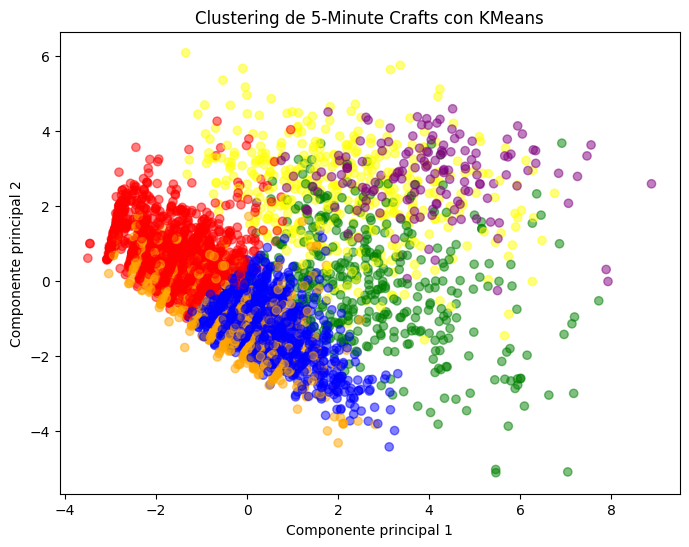

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
cluster_colors = [colors[label] for label in clusters]

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_colors, alpha=0.5)
plt.title('Clustering de 5-Minute Crafts con KMeans')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

Estadísticas descriptivas de 'total_views' por cluster:
                 count          mean           std      min       25%  \
cluster_label                                                          
0              1733.0  4.065566e+06  7.963679e+06  52001.0  631561.0   
1              1553.0  4.494481e+06  1.084570e+07  17810.0  629195.0   
2               389.0  3.291522e+06  5.515382e+06   5648.0  503267.0   
3               733.0  5.876011e+06  1.132106e+07  41577.0  705251.0   
4               153.0  9.314987e+05  6.365456e+06   4034.0   33760.0   
5               417.0  4.548707e+06  1.413699e+07  17834.0  447814.0   

                     50%        75%          max  
cluster_label                                     
0              1579187.0  4306550.0  178057735.0  
1              1486223.0  4504605.0  283031109.0  
2              1322384.0  3399335.0   46634625.0  
3              1872492.0  6323488.0  140700047.0  
4                71285.0   189370.0   76784201.0  
5        

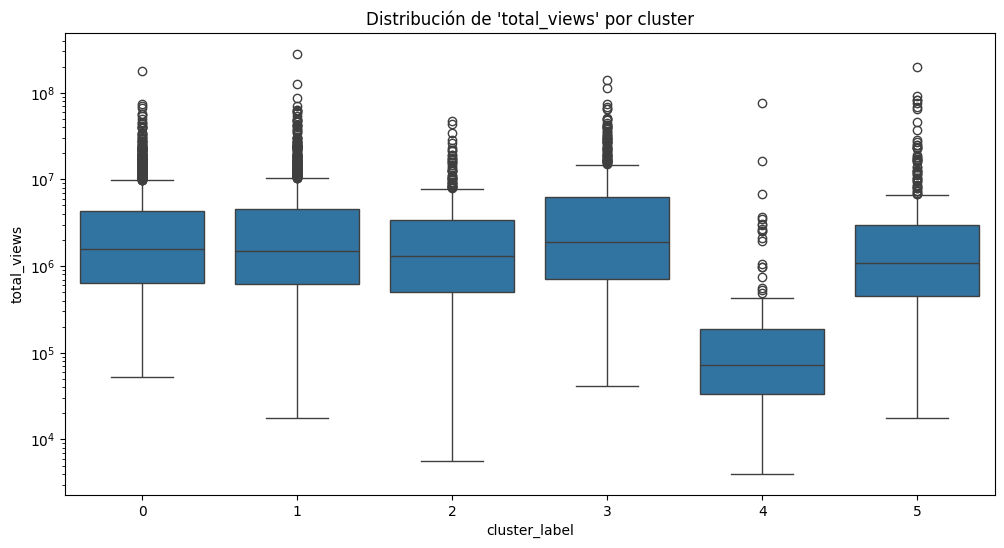

In [30]:
cluster_descriptive_stats = five_minute_crafts.groupby('cluster_label')['total_views'].describe()

cluster_mean_median = five_minute_crafts.groupby('cluster_label')['total_views'].agg(['mean', 'median'])

print("Estadísticas descriptivas de 'total_views' por cluster:\n", cluster_descriptive_stats)
print("\nMedia y mediana de 'total_views' por cluster:\n", cluster_mean_median)


import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_label', y='total_views', data=five_minute_crafts)
plt.title("Distribución de 'total_views' por cluster")
plt.yscale('log')  # mejor visualización
plt.show()

In [31]:
five_minute_crafts.to_csv('clustering_five_minute_crafts.csv',index=False)

In [32]:
five_minute_crafts = pd.read_csv(filepath_or_buffer="clustering_five_minute_crafts.csv")

### Añadir nuevas características para ver si así mejora

In [33]:
cluster_dummies = pd.get_dummies(five_minute_crafts['cluster_label'], prefix='cluster')

five_minute_crafts_with_dummies = pd.concat([five_minute_crafts, cluster_dummies], axis=1)

# Duración y cluster_laber
five_minute_crafts_with_dummies['duration_cluster_interaction'] = five_minute_crafts_with_dummies['duration_seconds'] * five_minute_crafts_with_dummies['cluster_label']

print(five_minute_crafts_with_dummies[['duration_seconds', 'cluster_label', 'duration_cluster_interaction']].head())

   duration_seconds  cluster_label  duration_cluster_interaction
0               623              5                          3115
1               739              2                          1478
2               960              5                          4800
3               833              5                          4165
4              3600              5                         18000


In [34]:
five_minute_crafts['duration_cluster_interaction'] = five_minute_crafts['duration_seconds'] * five_minute_crafts['cluster_label']

Vuelvo a comprobar mis modelos después de este proceso para ver si han mejorado o no:

In [35]:
X = five_minute_crafts.drop(['total_views', 'video_id', 'title', 'cluster_label'], axis=1)
y = five_minute_crafts['total_views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "SVR": SVR()
}

In [38]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {name}")
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print("-" * 40)

Model: Linear Regression
RMSE: 12090873.337612236
R^2: 0.021555999029479245
----------------------------------------
Model: Ridge Regression
RMSE: 12090276.555826977
R^2: 0.021652584798076413
----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+15, tolerance: 3.425e+13
  model = cd_fast.enet_coordinate_descent(


Model: Lasso Regression
RMSE: 12090872.657348162
R^2: 0.021556109129099554
----------------------------------------
Model: Elastic Net
RMSE: 12123309.378455317
R^2: 0.01629923738396777
----------------------------------------
Model: Random Forest Regressor
RMSE: 12335336.097959196
R^2: -0.018409884598946435
----------------------------------------
Model: Gradient Boosting Regressor
RMSE: 12113060.216750918
R^2: 0.017961794383025476
----------------------------------------
Model: XGBoost Regressor
RMSE: 12670136.479049858
R^2: -0.07444259647670326
----------------------------------------
Model: SVR
RMSE: 12631110.539105475
R^2: -0.06783389811059326
----------------------------------------


Se aprecia una leve mejoría, pero muy baja y no es suficiente. Estos modelos no valen.

----

# Clasificación por rangos

Tras los resultados obtenidos, voy a cambiar de estrategia y voy a clasificar los vídeos en 5 rangos: "muy malo", "malo","normal","bueno" y "muy bueno". Haciendo esto, trataré de predecir a que rango pertenecerá un nuevo vídeo cuando se suba al canal dependiendo del resto de variables. Es decir, trataré de predecir si el vídeo será un éxito o un fracaso:

In [39]:
five_minute_crafts = pd.read_csv('clean_five_minute_crafts.csv')

In [40]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,295614,60,12,2,4,0,2,5.000000,0,0,0.144444
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,130544,87,17,4,5,0,3,5.117647,0,0,0.086905
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,17834,33,6,0,6,0,2,5.500000,0,0,0.000000
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,3128867,66,12,2,5,0,3,5.500000,0,0,0.058333
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,4210362,56,10,1,5,0,4,5.600000,0,0,0.500000


In [41]:
five_minute_crafts['total_views'].describe()

count    4.978000e+03
mean     4.349619e+06
std      9.936944e+06
min      4.034000e+03
25%      5.679352e+05
50%      1.459397e+06
75%      4.271779e+06
max      2.830311e+08
Name: total_views, dtype: float64

* Vídeo muy malo: Menos de 10,000 visitas.
* Vídeo malo: 10,000 - 100,000 visitas.
* Vídeo normal: 100,000 - 1,000,000 visitas.
* Vídeo bueno: 1,000,000 - 10,000,000 visitas.
* Supervideo: Más de 10,000,000 visitas.

In [42]:
# Definir los rangos de visitas
ranges = [0, 10000, 100000, 1000000, 10000000, float('inf')]
labels = ["very bad video", "bad video", "normal", "good video", "super video"]

# Clasificar los datos según los rangos
five_minute_crafts['popularity_group'] = pd.cut(five_minute_crafts['total_views'], bins=ranges, labels=labels)

five_minute_crafts.drop('total_views', axis=1, inplace=True)

five_minute_crafts.to_csv('videos_classified.csv', index=False)


In [43]:
five_minute_crafts = pd.read_csv('videos_classified.csv')

In [44]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,popularity_group
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,normal
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,normal
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,bad video
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,good video
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,good video


In [45]:
custom_mapping = {'bad video': 1, 'good video': 3, 'normal': 2, 'super video': 4, 'very bad video': 0}

label_encoder = LabelEncoder()
label_encoder.fit(list(custom_mapping.keys()))

# Aplicar el mapeo y codificar en números
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_group'].map(custom_mapping)

print(five_minute_crafts[['popularity_group', 'popularity_encoded']].head())


  popularity_group  popularity_encoded
0           normal                   2
1           normal                   2
2        bad video                   1
3       good video                   3
4       good video                   3


In [46]:
five_minute_crafts.drop('popularity_group', axis=1, inplace=True)

In [47]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,popularity_encoded
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,2
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,2
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,1
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,3
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,3


<Axes: >

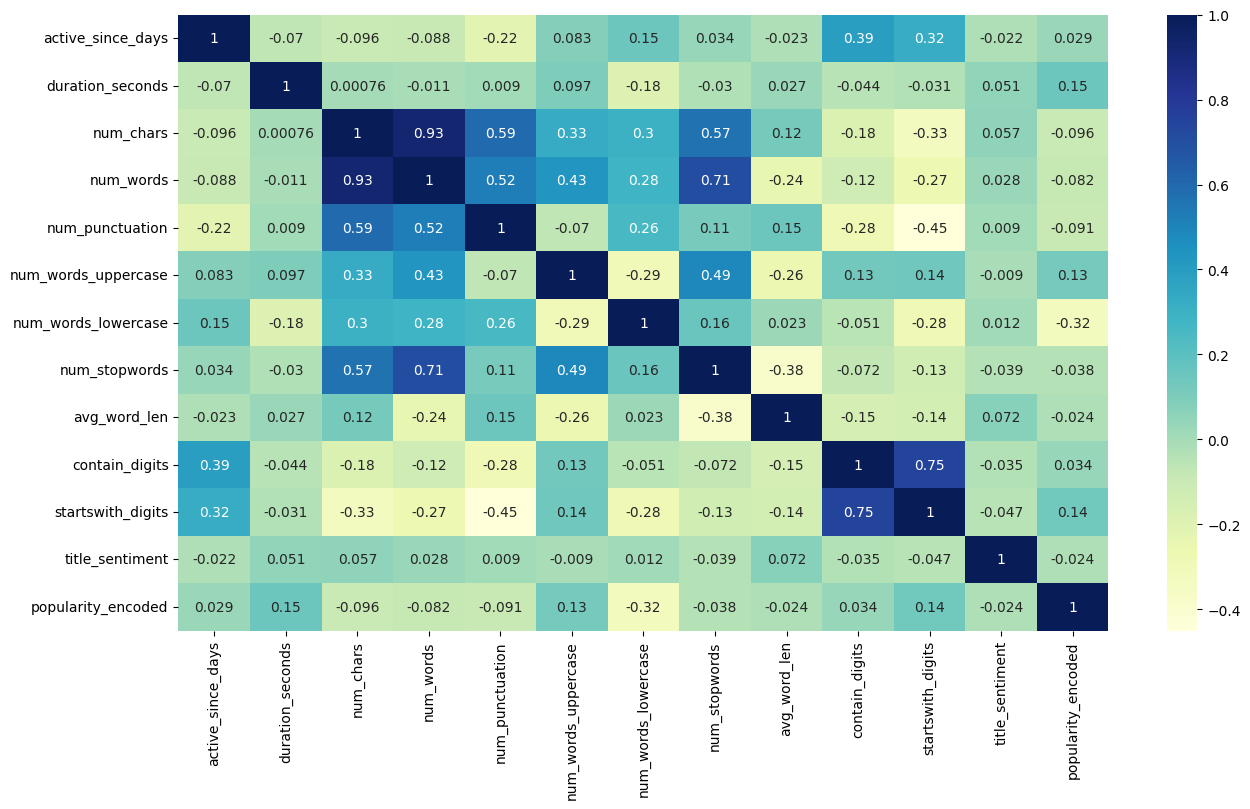

In [48]:
corr = five_minute_crafts.drop(['video_id', 'title'], axis=1).corr()

plt.figure(figsize=(15, 8))
sb.heatmap(corr, annot=True, cmap='YlGnBu')

In [49]:
five_minute_crafts.corr()['popularity_encoded'].sort_values(ascending=False)

<ipython-input-49-069076ff11e8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  five_minute_crafts.corr()['popularity_encoded'].sort_values(ascending=False)


popularity_encoded     1.000000
duration_seconds       0.146549
startswith_digits      0.137239
num_words_uppercase    0.127940
contain_digits         0.034159
active_since_days      0.028914
title_sentiment       -0.023806
avg_word_len          -0.024337
num_stopwords         -0.037940
num_words             -0.081892
num_punctuation       -0.091394
num_chars             -0.096396
num_words_lowercase   -0.324812
Name: popularity_encoded, dtype: float64

Tras este breve análisis de correlación, parece que los vídeos con una duración más larga, títulos que comienzan con dígitos y un mayor número de palabras en mayúsculas tienden a tener una mayor popularidad.

### Separo X e y. Entreno los modelos

In [50]:
X = five_minute_crafts.drop(['video_id','title','popularity_encoded'], axis=1)
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Linear SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier()
}

In [53]:
# Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)
y_pred_lr = logistic_regression.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.5261044176706827


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
# Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_scaled, y_train)
y_pred_rc = ridge_classifier.predict(X_test_scaled)
accuracy_rc = accuracy_score(y_test, y_pred_rc)
print("Ridge Classifier Accuracy:", accuracy_rc)


Ridge Classifier Accuracy: 0.5230923694779116


In [55]:
# Support Vector Machine
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)


Support Vector Machine Accuracy: 0.5491967871485943


In [56]:
# Linear SVM
linear_svm_classifier = LinearSVC()
linear_svm_classifier.fit(X_train_scaled, y_train)
y_pred_lsvm = linear_svm_classifier.predict(X_test_scaled)
accuracy_lsvm = accuracy_score(y_test, y_pred_lsvm)
print("Linear SVM Accuracy:", accuracy_lsvm)

Linear SVM Accuracy: 0.5261044176706827


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [57]:
# Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_scaled, y_train)
y_pred_dt = decision_tree_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.463855421686747


In [58]:
# Random Forest
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.5180722891566265


In [59]:
# AdaBoost
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_scaled, y_train)
y_pred_ab = adaboost_classifier.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
print("AdaBoost Accuracy:", accuracy_ab)

AdaBoost Accuracy: 0.25903614457831325


In [60]:
# Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boosting_classifier.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5572289156626506


In [61]:
# XGBoost
xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgboost_classifier.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.5190763052208835


In [62]:
# CatBoost
catboost_classifier = CatBoostClassifier(verbose=False)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)

CatBoost Accuracy: 0.5371485943775101


El modelo de Gradient Boosting parece ser el mejor. Voy a tratar de mejorarlo:

#### Ajustar parametros usando GridSearchCV

In [63]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


print("Mejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [64]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred_gb = best_gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5612449799196787


- Antes = 0.5502008032128514

- Ahora = 0.5612449799196787

Hay una pequeña mejoría tras aplicarl el GridSearchCV.

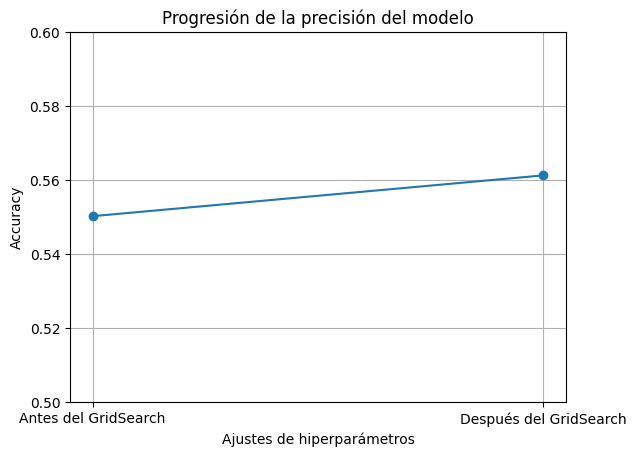

In [65]:
precisions = [0.5502008032128514, 0.5612449799196787]

labels = ['Antes del GridSearch', 'Después del GridSearch']

plt.plot(labels, precisions, marker='o', linestyle='-')
plt.ylim(0.5, 0.6)
plt.xlabel('Ajustes de hiperparámetros')
plt.ylabel('Accuracy')
plt.title('Progresión de la precisión del modelo')
plt.grid(True)
plt.show()

#### Calcular el rendimiento del modelo con validación cruzada

In [66]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)

# Validación cruzada
cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

mean_cv_score = cv_scores.mean()

print("Puntajes de validación cruzada:", cv_scores)
print("Precisión media:", mean_cv_score)


Puntajes de validación cruzada: [0.56461731 0.57841907 0.56281407 0.57663317 0.5678392 ]
Precisión media: 0.5700645637219977


 ### Uso de SMOTE (técnica de sobremuestreo) para el desbalanceo de clases de datos

In [67]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [68]:
gradient_boosting_classifier_smote= GradientBoostingClassifier()
gradient_boosting_classifier_smote.fit(X_train_resampled, y_train_resampled)
y_pred_gb_smote = gradient_boosting_classifier_smote.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5612449799196787


No mejora aplicando Smote. Así que voy a intentar mejorar el modelo teniendo en cuenta la popularidad de las 5 palabaras más repetidas en los títulos:

In [69]:
five_minute_crafts = pd.read_csv('videos_classified.csv')

---------------

In [70]:
most_popular_words = ['hacks', 'life', 'ideas','DIY', 'crafts']

# Crear una columna
five_minute_crafts['most_popular_words'] = five_minute_crafts['title'].str.lower()

dummies = pd.get_dummies(five_minute_crafts['most_popular_words'].apply(lambda x: pd.Series([1 if palabra in x else 0 for palabra in most_popular_words], index=most_popular_words)))
five_minute_crafts = pd.concat([five_minute_crafts, dummies], axis=1)

# Eliminar la columna 'most_popular_words'
five_minute_crafts.drop('most_popular_words', axis=1, inplace=True)


five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,popularity_group,hacks,life,ideas,DIY,crafts
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,normal,1,1,0,0,0
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,normal,1,0,1,0,0
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,bad video,1,1,0,0,0
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,good video,1,0,0,0,0
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,good video,1,0,0,0,1


In [71]:
custom_mapping = {'bad video': 1, 'good video': 3, 'normal': 2, 'super video': 4, 'very bad video': 0}

label_encoder = LabelEncoder()
label_encoder.fit(list(custom_mapping.keys()))

# Aplicar el mapeo y codificar en números
five_minute_crafts['popularity_encoded'] = five_minute_crafts['popularity_group'].map(custom_mapping)

print(five_minute_crafts[['popularity_group', 'popularity_encoded']].head())

  popularity_group  popularity_encoded
0           normal                   2
1           normal                   2
2        bad video                   1
3       good video                   3
4       good video                   3


In [72]:
five_minute_crafts.drop('popularity_group', axis=1, inplace=True)

In [73]:
five_minute_crafts.to_csv('videos_classified_and_popular_words.csv', index=False)

In [74]:
five_minute_crafts = pd.read_csv('videos_classified_and_popular_words.csv')

In [75]:
five_minute_crafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             4978 non-null   object 
 1   title                4978 non-null   object 
 2   active_since_days    4978 non-null   int64  
 3   duration_seconds     4978 non-null   int64  
 4   num_chars            4978 non-null   int64  
 5   num_words            4978 non-null   int64  
 6   num_punctuation      4978 non-null   int64  
 7   num_words_uppercase  4978 non-null   int64  
 8   num_words_lowercase  4978 non-null   int64  
 9   num_stopwords        4978 non-null   int64  
 10  avg_word_len         4978 non-null   float64
 11  contain_digits       4978 non-null   int64  
 12  startswith_digits    4978 non-null   int64  
 13  title_sentiment      4978 non-null   float64
 14  hacks                4978 non-null   int64  
 15  life                 4978 non-null   i

<Axes: >

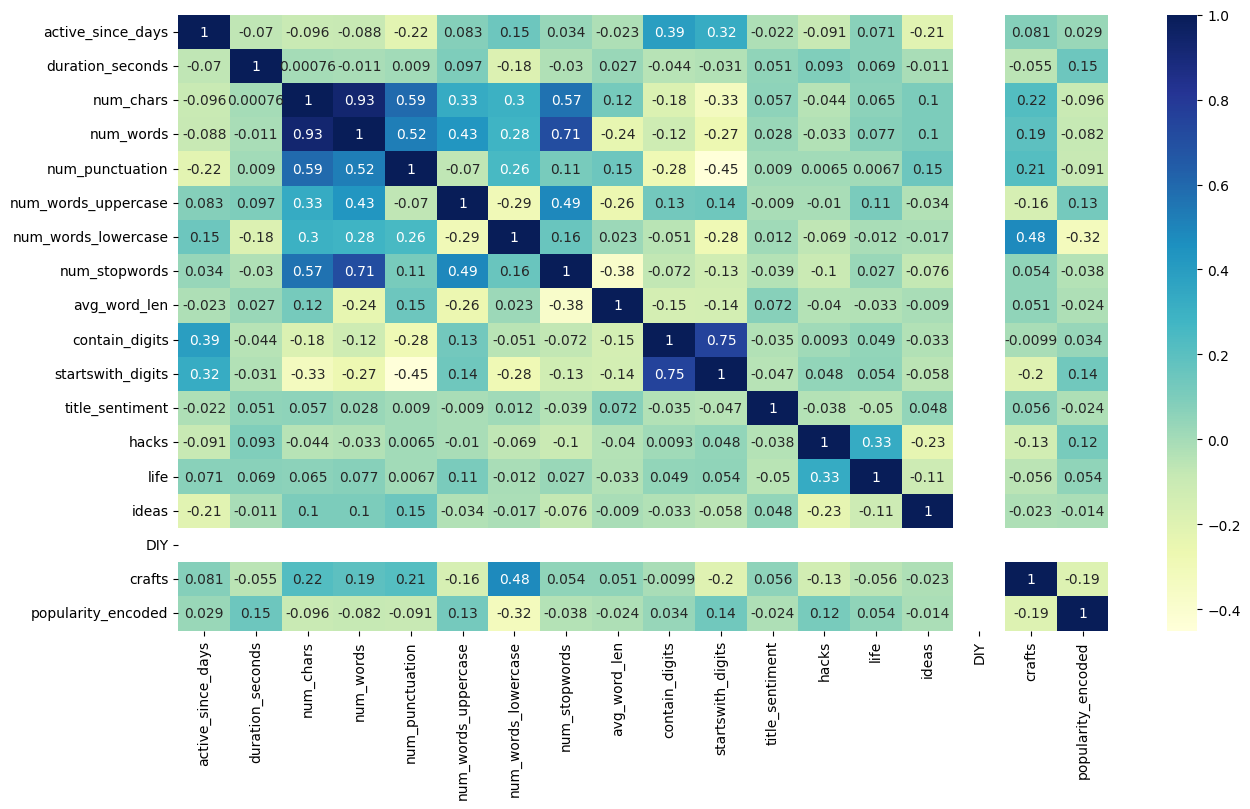

In [76]:
corr = five_minute_crafts.drop(['video_id', 'title'], axis=1).corr()

plt.figure(figsize=(15, 8))
sb.heatmap(corr, annot=True, cmap='YlGnBu')

In [77]:
five_minute_crafts.corr()['popularity_encoded'].sort_values(ascending=False)

<ipython-input-77-069076ff11e8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  five_minute_crafts.corr()['popularity_encoded'].sort_values(ascending=False)


popularity_encoded     1.000000
duration_seconds       0.146549
startswith_digits      0.137239
num_words_uppercase    0.127940
hacks                  0.115852
life                   0.054243
contain_digits         0.034159
active_since_days      0.028914
ideas                 -0.013948
title_sentiment       -0.023806
avg_word_len          -0.024337
num_stopwords         -0.037940
num_words             -0.081892
num_punctuation       -0.091394
num_chars             -0.096396
crafts                -0.191591
num_words_lowercase   -0.324812
DIY                         NaN
Name: popularity_encoded, dtype: float64

In [78]:
X = five_minute_crafts.drop(['video_id','title','popularity_encoded'], axis=1)
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
# Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)
y_pred_lr = logistic_regression.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.5301204819277109


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
importances_lr = logistic_regression.coef_
print("Logistic Regression Coefficients:", importances_lr)

Logistic Regression Coefficients: [[ 4.34217197e-01 -5.30263772e-01  3.50969129e-01  1.26879605e-01
  -1.40326038e-01 -1.83365690e-01  2.16715599e-01  1.27015918e-01
   2.59646356e-01  2.68476019e-01 -4.33176055e-01  1.06457782e-02
   1.99774691e-01 -1.81167740e-02  2.16637924e-02  0.00000000e+00
   4.27771569e-01]
 [ 8.50768360e-01 -2.43520219e-01 -7.48941509e-02  6.27152162e-02
   2.83868258e-02 -1.58500855e-01  2.55506496e-01 -1.83856747e-01
   1.72642385e-01 -8.14337278e-02  7.27981709e-02  2.81787985e-02
  -2.84288877e-01  2.99332777e-01  1.43456232e-02  0.00000000e+00
   3.63975147e-01]
 [-6.85768890e-01  8.37164944e-02  2.60895623e-01 -4.05434711e-01
   1.63034660e-02  8.72377283e-02 -3.92210440e-02  3.01776414e-02
  -2.55530214e-01  1.24499339e-03  7.00151236e-02  3.11901355e-02
  -1.04065866e-01 -9.91047154e-02 -7.78899428e-02  0.00000000e+00
  -3.12230937e-01]
 [-4.62772802e-01  3.32023900e-01  2.98015757e-01 -3.75278029e-01
   1.24491399e-02  1.36050233e-01 -1.87033284e-01 -

In [82]:
# Obtener el número de clases
num_clases = len(importances_lr)

# Iterar sobre cada clase
for clase in range(num_clases):
    # Obtener los coeficientes para la clase actual
    coef_clase = importances_lr[clase]

    # Obtener los índices de las cinco características más relevantes
    indices_top5 = np.argsort(np.abs(coef_clase))[::-1][:5]

    # Obtener los nombres de las características correspondientes a los índices seleccionados
    nombres_top5 = X.columns[indices_top5]

    # Imprimir los nombres de las características más relevantes para la clase actual
    print(f"Las cinco características más relevantes para la clase {clase} son:")
    print(nombres_top5)
    print()


Las cinco características más relevantes para la clase 0 son:
Index(['duration_seconds', 'active_since_days', 'startswith_digits', 'crafts',
       'num_chars'],
      dtype='object')

Las cinco características más relevantes para la clase 1 son:
Index(['active_since_days', 'crafts', 'life', 'hacks', 'num_words_lowercase'], dtype='object')

Las cinco características más relevantes para la clase 2 son:
Index(['active_since_days', 'num_words', 'crafts', 'num_chars',
       'avg_word_len'],
      dtype='object')

Las cinco características más relevantes para la clase 3 son:
Index(['active_since_days', 'num_words', 'duration_seconds', 'crafts',
       'num_chars'],
      dtype='object')

Las cinco características más relevantes para la clase 4 son:
Index(['num_chars', 'num_words', 'duration_seconds', 'num_words_lowercase',
       'contain_digits'],
      dtype='object')



In [83]:
# Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_scaled, y_train)
y_pred_rc = ridge_classifier.predict(X_test_scaled)
accuracy_rc = accuracy_score(y_test, y_pred_rc)
print("Ridge Classifier Accuracy:", accuracy_rc)

Ridge Classifier Accuracy: 0.5271084337349398


In [84]:
# Obtener los coeficientes del RidgeClassifier
coeficientes = ridge_classifier.coef_

# Obtener los nombres de las características
nombres_caracteristicas = X.columns

# Iterar sobre cada clase
for clase in range(coeficientes.shape[0]):
    # Obtener la importancia de las características para la clase actual
    importancia_caracteristicas = np.abs(coeficientes[clase])

    # Obtener los índices de las características más importantes
    indices_top5 = np.argsort(importancia_caracteristicas)[::-1][:5]

    # Obtener los nombres de las características más importantes
    nombres_top5 = nombres_caracteristicas[indices_top5]

    # Imprimir los nombres de las características más importantes para la clase actual
    print(f"Las cinco características más relevantes para la clase {clase} son:")
    print(nombres_top5)
    print()


Las cinco características más relevantes para la clase 0 son:
Index(['num_words', 'num_chars', 'num_words_lowercase', 'startswith_digits',
       'contain_digits'],
      dtype='object')

Las cinco características más relevantes para la clase 1 son:
Index(['num_words_lowercase', 'num_words', 'num_chars', 'crafts',
       'active_since_days'],
      dtype='object')

Las cinco características más relevantes para la clase 2 son:
Index(['active_since_days', 'hacks', 'duration_seconds', 'num_words', 'ideas'], dtype='object')

Las cinco características más relevantes para la clase 3 son:
Index(['num_chars', 'num_words_lowercase', 'num_words', 'duration_seconds',
       'hacks'],
      dtype='object')

Las cinco características más relevantes para la clase 4 son:
Index(['num_chars', 'num_words', 'avg_word_len', 'active_since_days',
       'num_words_lowercase'],
      dtype='object')



In [85]:
# Support Vector Machine
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)

Support Vector Machine Accuracy: 0.5451807228915663


In [86]:
# Obtener los vectores de soporte
support_vectors = svm_classifier.support_vectors_

# Obtener los coeficientes de los vectores de soporte
dual_coef = svm_classifier.dual_coef_

# Calcular el producto punto entre los vectores de soporte y los coeficientes
importancia_caracteristicas = np.abs(np.dot(dual_coef, support_vectors))

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancia_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = nombres_caracteristicas[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
[['DIY' 'num_words_uppercase' 'num_words' 'contain_digits' 'crafts'
  'num_stopwords' 'num_words_lowercase' 'hacks' 'avg_word_len'
  'startswith_digits' 'num_chars' 'num_punctuation' 'title_sentiment'
  'duration_seconds' 'ideas' 'life' 'active_since_days']
 ['DIY' 'contain_digits' 'num_stopwords' 'ideas' 'avg_word_len'
  'title_sentiment' 'num_words' 'startswith_digits' 'life'
  'num_punctuation' 'hacks' 'num_chars' 'active_since_days'
  'num_words_uppercase' 'crafts' 'duration_seconds' 'num_words_lowercase']
 ['DIY' 'title_sentiment' 'life' 'ideas' 'num_words' 'num_chars'
  'num_stopwords' 'active_since_days' 'startswith_digits' 'crafts'
  'num_words_uppercase' 'num_punctuation' 'contain_digits' 'hacks'
  'avg_word_len' 'duration_seconds' 'num_words_lowercase']
 ['DIY' 'ideas' 'duration_seconds' 'title_sentiment' 'contain_digits'
  'life' 'avg_word_len' 'hacks' 'active_since_days' 'num_stopwords'
  'num_words_uppercase' 'num_words' 'num_p

<ipython-input-86-b63ed2fdef58>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nombres_top5 = nombres_caracteristicas[indices_top5]


In [87]:
# Linear SVM
linear_svm_classifier = LinearSVC()
linear_svm_classifier.fit(X_train_scaled, y_train)
y_pred_lsvm = linear_svm_classifier.predict(X_test_scaled)
accuracy_lsvm = accuracy_score(y_test, y_pred_lsvm)
print("Linear SVM Accuracy:", accuracy_lsvm)

Linear SVM Accuracy: 0.5281124497991968


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [88]:
# Obtener los coeficientes de las características del modelo Linear SVM
coeficientes = linear_svm_classifier.coef_

# Obtener el valor absoluto de los coeficientes para obtener la importancia
importancia_caracteristicas = np.abs(coeficientes)

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancia_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
[['DIY' 'num_words_uppercase' 'startswith_digits' 'title_sentiment'
  'ideas' 'num_punctuation' 'num_stopwords' 'crafts' 'life'
  'duration_seconds' 'hacks' 'contain_digits' 'num_words_lowercase'
  'active_since_days' 'avg_word_len' 'num_words' 'num_chars']
 ['DIY' 'num_punctuation' 'contain_digits' 'title_sentiment'
  'num_words_uppercase' 'ideas' 'crafts' 'startswith_digits'
  'num_stopwords' 'active_since_days' 'life' 'avg_word_len' 'hacks'
  'duration_seconds' 'num_words' 'num_words_lowercase' 'num_chars']
 ['DIY' 'num_punctuation' 'contain_digits' 'life' 'startswith_digits'
  'avg_word_len' 'title_sentiment' 'num_words_uppercase' 'num_stopwords'
  'crafts' 'num_chars' 'num_words_lowercase' 'ideas' 'num_words' 'hacks'
  'duration_seconds' 'active_since_days']
 ['DIY' 'ideas' 'title_sentiment' 'contain_digits' 'num_punctuation'
  'avg_word_len' 'num_words_uppercase' 'startswith_digits' 'hacks' 'life'
  'num_stopwords' 'duration_seconds' 

<ipython-input-88-7d95d7c3b925>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nombres_top5 = X.columns[indices_top5]


In [89]:
# Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_scaled, y_train)
y_pred_dt = decision_tree_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.4387550200803213


In [90]:
# Obtener las importancias de características del modelo de árbol de decisión
importancias_caracteristicas = decision_tree_classifier.feature_importances_

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancias_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
Index(['duration_seconds', 'avg_word_len', 'title_sentiment', 'num_chars',
       'active_since_days'],
      dtype='object')


In [91]:
# Random Forest
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.5080321285140562


In [92]:
# Obtener las importancias de características del modelo de Random Forest
importancias_caracteristicas = random_forest_classifier.feature_importances_

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancias_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
Index(['duration_seconds', 'avg_word_len', 'title_sentiment', 'num_chars',
       'active_since_days'],
      dtype='object')


In [93]:
# AdaBoost
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_scaled, y_train)
y_pred_ab = adaboost_classifier.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
print("AdaBoost Accuracy:", accuracy_ab)

AdaBoost Accuracy: 0.25903614457831325


In [94]:
# Obtener las importancias de características del modelo de AdaBoost
importancias_caracteristicas = adaboost_classifier.feature_importances_

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancias_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
Index(['active_since_days', 'duration_seconds', 'avg_word_len', 'life',
       'hacks'],
      dtype='object')


In [95]:
# Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boosting_classifier.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5481927710843374


In [96]:
# Obtener las importancias de características del modelo de Gradient Boosting
importancias_caracteristicas = gradient_boosting_classifier.feature_importances_

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancias_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
Index(['duration_seconds', 'active_since_days', 'num_chars', 'avg_word_len',
       'title_sentiment'],
      dtype='object')


In [97]:
# XGBoost
xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgboost_classifier.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.5100401606425703


In [98]:
# Obtener las importancias de características del modelo XGBoost
importancias_caracteristicas = xgboost_classifier.feature_importances_

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancias_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
Index(['active_since_days', 'duration_seconds', 'ideas', 'life', 'crafts'], dtype='object')


In [99]:
# CatBoost
catboost_classifier = CatBoostClassifier(verbose=False)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)

CatBoost Accuracy: 0.5291164658634538


In [100]:
# Obtener las importancias de características del modelo CatBoost
importancias_caracteristicas = catboost_classifier.feature_importances_

# Obtener los índices de las características más importantes
indices_top5 = np.argsort(importancias_caracteristicas)[::-1][:5]

# Obtener los nombres de las características más importantes
nombres_top5 = X.columns[indices_top5]

# Imprimir los nombres de las características más importantes
print("Las cinco características más relevantes son:")
print(nombres_top5)


Las cinco características más relevantes son:
Index(['duration_seconds', 'active_since_days', 'title_sentiment',
       'avg_word_len', 'num_chars'],
      dtype='object')


Este es el ranking de las 5 variables más relevantes para los modelos:
- duration_seconds
- active_since_days
- avg_word_len
- num_chars
- title_sentiment

Para ver si los modelos mejoran, solo me voy a quedar con estas variables para entrenar

In [101]:
five_minute_crafts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             4978 non-null   object 
 1   title                4978 non-null   object 
 2   active_since_days    4978 non-null   int64  
 3   duration_seconds     4978 non-null   int64  
 4   num_chars            4978 non-null   int64  
 5   num_words            4978 non-null   int64  
 6   num_punctuation      4978 non-null   int64  
 7   num_words_uppercase  4978 non-null   int64  
 8   num_words_lowercase  4978 non-null   int64  
 9   num_stopwords        4978 non-null   int64  
 10  avg_word_len         4978 non-null   float64
 11  contain_digits       4978 non-null   int64  
 12  startswith_digits    4978 non-null   int64  
 13  title_sentiment      4978 non-null   float64
 14  hacks                4978 non-null   int64  
 15  life                 4978 non-null   i

In [102]:
X = five_minute_crafts.drop(['video_id','title','popularity_encoded','num_words','num_punctuation','num_words_uppercase',
                             'num_words_lowercase','num_stopwords','contain_digits','startswith_digits','hacks','life',
                             'ideas','DIY','crafts'], axis=1)
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
# Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)
y_pred_lr = logistic_regression.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.5271084337349398


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
# Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_scaled, y_train)
y_pred_rc = ridge_classifier.predict(X_test_scaled)
accuracy_rc = accuracy_score(y_test, y_pred_rc)
print("Ridge Classifier Accuracy:", accuracy_rc)

Ridge Classifier Accuracy: 0.5090361445783133


In [106]:
# Support Vector Machine
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)

Support Vector Machine Accuracy: 0.5542168674698795


In [107]:
# Linear SVM
linear_svm_classifier = LinearSVC()
linear_svm_classifier.fit(X_train_scaled, y_train)
y_pred_lsvm = linear_svm_classifier.predict(X_test_scaled)
accuracy_lsvm = accuracy_score(y_test, y_pred_lsvm)
print("Linear SVM Accuracy:", accuracy_lsvm)

Linear SVM Accuracy: 0.5150602409638554


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [108]:
# Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_scaled, y_train)
y_pred_dt = decision_tree_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.46285140562248994


In [109]:
# Random Forest
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train_scaled, y_train)
y_pred_rf = random_forest_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.5210843373493976


In [110]:
# AdaBoost
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_scaled, y_train)
y_pred_ab = adaboost_classifier.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, y_pred_ab)
print("AdaBoost Accuracy:", accuracy_ab)

AdaBoost Accuracy: 0.25903614457831325


In [111]:
# Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train_scaled, y_train)
y_pred_gb = gradient_boosting_classifier.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5582329317269076


In [112]:
# XGBoost
xgboost_classifier = XGBClassifier()
xgboost_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgboost_classifier.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.5281124497991968


In [113]:
# CatBoost
catboost_classifier = CatBoostClassifier(verbose=False)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred_catboost = catboost_classifier.predict(X_test_scaled)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", accuracy_catboost)

CatBoost Accuracy: 0.5200803212851406


El mejor sigue siendo Gradient Boosting con un Accuracy de 0.5622489959839357. Al entrenarlo solo con estas variables mejora, pero trataré de afinarlo más:

In [114]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [115]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred_gb = best_gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5642570281124498


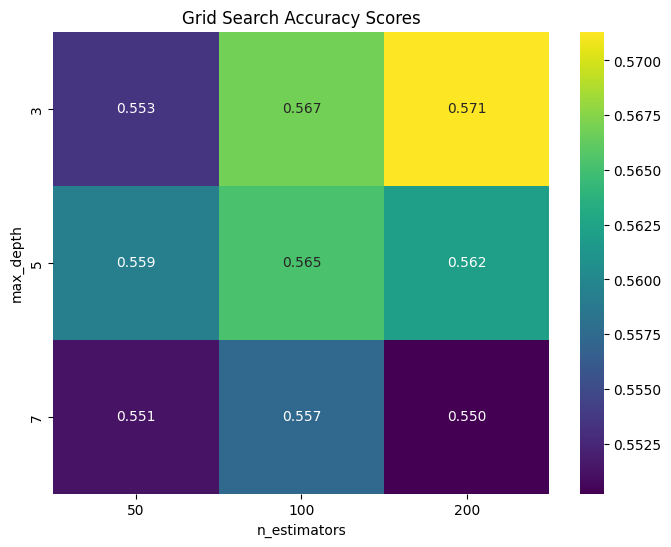

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


# Obtener los resultados de la búsqueda de cuadrícula
cv_results = grid_search.cv_results_

# Encontrar el número de valores diferentes para 'n_estimators' y 'max_depth'
n_estimators_range = param_grid['n_estimators']
max_depth_range = param_grid['max_depth']
learning_rate_range = param_grid['learning_rate']

# Crear la matriz de puntajes de precisión para cada combinación de 'n_estimators' y 'max_depth'
# 'learning_rate' se fijará en el mejor valor encontrado
scores_matrix = np.array([
    cv_results['mean_test_score'][
        (cv_results['param_learning_rate'] == grid_search.best_params_['learning_rate']) &
        (cv_results['param_n_estimators'] == n_estimator) &
        (cv_results['param_max_depth'] == max_depth)
    ]
    for max_depth in max_depth_range
    for n_estimator in n_estimators_range
]).reshape(len(max_depth_range), len(n_estimators_range))

plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", xticklabels=n_estimators_range, yticklabels=max_depth_range, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('Grid Search Accuracy Scores')
plt.show()


In [117]:
best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)

# Validación cruzada
cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

mean_cv_score = cv_scores.mean()

print("Puntajes de validación cruzada:", cv_scores)
print("Precisión media:", mean_cv_score)

Puntajes de validación cruzada: [0.56963614 0.57590966 0.5678392  0.57160804 0.57160804]
Precisión media: 0.5713202146239353


#### Mejora, pero voy a ver si mejora con modelos no supervisados

No voy a usar PCA porque no tengo muchas columnas, directamente hago clustering:

In [118]:
features_important = ['duration_seconds','active_since_days','avg_word_len',
'num_chars','title_sentiment']


features = five_minute_crafts[features_important]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Aplicar K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Agregar la asignación de cluster al DataFrame
five_minute_crafts['cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


------

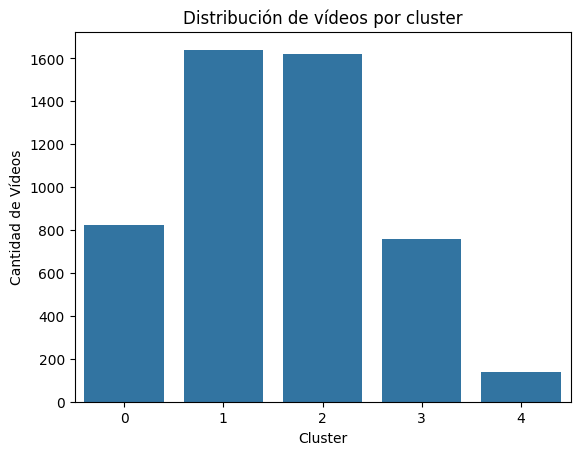

In [119]:
# Visualiza de los clusters
sns.countplot(x='cluster', data=five_minute_crafts)
plt.title('Distribución de vídeos por cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de Vídeos')
plt.show()


In [120]:
for i in range(kmeans.n_clusters):
    print(f"\nCaracterísticas promedio del Cluster {i}:")
    cluster_means = five_minute_crafts[five_minute_crafts['cluster'] == i][features_important].mean()
    print(cluster_means)



Características promedio del Cluster 0:
duration_seconds     815.332117
active_since_days    369.761557
avg_word_len           5.487317
num_chars             61.281022
title_sentiment        0.326842
dtype: float64

Características promedio del Cluster 1:
duration_seconds      827.235976
active_since_days    1272.381098
avg_word_len            5.348836
num_chars              46.720122
title_sentiment         0.250087
dtype: float64

Características promedio del Cluster 2:
duration_seconds     851.371605
active_since_days    652.387654
avg_word_len           5.094719
num_chars             35.837037
title_sentiment        0.056758
dtype: float64

Características promedio del Cluster 3:
duration_seconds     842.748021
active_since_days    775.641161
avg_word_len           6.450799
num_chars             38.894459
title_sentiment        0.394652
dtype: float64

Características promedio del Cluster 4:
duration_seconds     4323.913043
active_since_days     618.688406
avg_word_len            

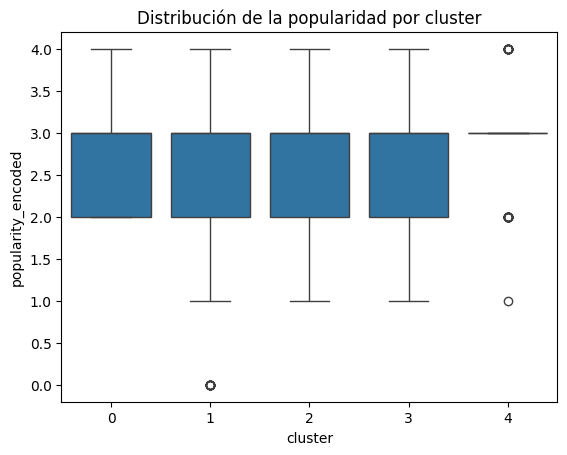


Popularidad promedio del Cluster 0:
2.5802919708029197

Popularidad promedio del Cluster 1:
2.629268292682927

Popularidad promedio del Cluster 2:
2.6950617283950615

Popularidad promedio del Cluster 3:
2.7440633245382586

Popularidad promedio del Cluster 4:
2.9130434782608696


In [121]:
# Cómo se distribuye la popularidad en cada cluster
sns.boxplot(x='cluster', y='popularity_encoded', data=five_minute_crafts)
plt.title('Distribución de la popularidad por cluster')
plt.show()

# Popularidad promedio por cluster
for i in range(kmeans.n_clusters):
    print(f"\nPopularidad promedio del Cluster {i}:")
    popularity_mean = five_minute_crafts[five_minute_crafts['cluster'] == i]['popularity_encoded'].mean()
    print(popularity_mean)


Ahora que tengo infromación de los diferentes clusters,los voy a incluir como una nueva característica en mi conjunto de datos y volveré a entrenar el modelo:

In [122]:
features = ['duration_seconds', 'active_since_days', 'avg_word_len', 'num_chars', 'title_sentiment', 'cluster']

X = five_minute_crafts[features]
y = five_minute_crafts['popularity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42)
best_gb_model.fit(X_train_scaled, y_train)

y_pred_gb = best_gb_model.predict(X_test_scaled)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

Gradient Boosting Accuracy: 0.5652610441767069


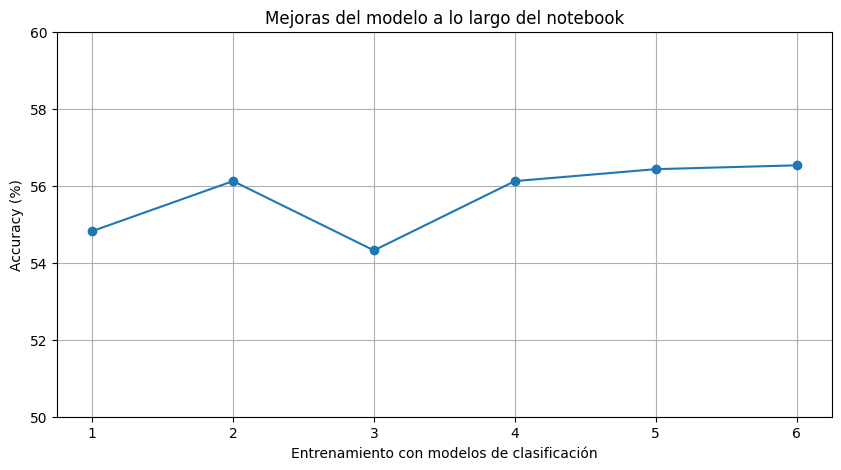

In [125]:
# Iteraciones
iteration_list = [1, 2, 3, 4, 5,6]

accuracy_list = [54.82, 56.12, 54.32, 56.12, 56.43, 56.53]

plt.figure(figsize=(10, 5))
plt.plot(iteration_list, accuracy_list, marker='o', linestyle='-')
plt.title('Mejoras del modelo a lo largo del notebook')
plt.xlabel('Entrenamiento con modelos de clasificación')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(iteration_list)
plt.ylim([50, 60])
plt.show()


Mejora levemente, pero prácticamente de manera insignificante por lo que no varía mucho aplicar estas herramientas de no supervisados.Así que voy a tratar de seguir mejorando usando técnicas de NLP:

In [4]:
five_minute_crafts = pd.read_csv('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/data/processed/videos_classified_and_popular_words.csv')

In [5]:
five_minute_crafts.head()

,video_id,title,active_since_days,duration_seconds,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment,hacks,life,ideas,DIY,crafts,popularity_encoded
0,v=XHTofu5wbbM,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...,22,623,60,12,2,4,0,2,5.000000,0,0,0.144444,1,1,0,0,0,2
1,v=HGxx0umIQvk,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...,1,739,87,17,4,5,0,3,5.117647,0,0,0.086905,1,0,1,0,0,2
2,v=Tt4RMk3Ih04,HELPFUL LIFE HACKS FOR YOUR HOUSE,1,960,33,6,0,6,0,2,5.500000,0,0,0.000000,1,1,0,0,0,1
3,v=A2MTydM5e58,USEFUL HACKS FOR YOUR HOME || Simple Tips That...,30,833,66,12,2,5,0,3,5.500000,0,0,0.058333,1,0,0,0,0,3
4,v=_halJ4yrmGQ,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...,15,3600,56,10,1,5,0,4,5.600000,0,0,0.500000,1,0,0,0,1,3


### Convertir los títulos, que son cadenas de texto, en una forma que la red pueda entender: números (tokenización)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(five_minute_crafts['title'])
sequences = tokenizer.texts_to_sequences(five_minute_crafts['title'])
print("Título original:", five_minute_crafts['title'].iloc[0])
print("Título tokenizado:", sequences[0])

# Tamaño del vocabulario
vocab_size = len(tokenizer.word_index) + 1
vocab_size

Título original: SUPER LAZY LIFE HACKS || Cool Hacks To Make Your Life Easier
Título tokenizado: [182, 196, 6, 1, 18, 1, 2, 12, 5, 6, 65]


2147

### Aplicar Padding a las Secuencias

In [8]:
from keras.preprocessing.sequence import pad_sequences
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print("Shape de las secuencias con padding:", padded_sequences.shape)

Shape de las secuencias con padding: (4978, 19)


In [9]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(five_minute_crafts['popularity_encoded'])
num_classes = labels.shape[1]
num_classes

5

### Construir red neuronal

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_shape=(max_length,)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(num_classes, activation='softmax')  # Ajuste para clasificación multiclase
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 19, 50)         │       107,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 950)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         9,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,915 (456.70 KB)

 Trainable params: 116,915 (456.70 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

In [11]:
history = model.fit(padded_sequences, labels,
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.2) 

Epoch 1/20


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4095 - loss: 1.2629 - val_accuracy: 0.4076 - val_loss: 1.5388
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5141 - loss: 0.9384 - val_accuracy: 0.4227 - val_loss: 1.6598
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5378 - loss: 0.9137 - val_accuracy: 0.4588 - val_loss: 1.6922
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 0.8744 - val_accuracy: 0.4709 - val_loss: 1.7671
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 0.8093 - val_accuracy: 0.4598 - val_loss: 1.7433
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6997 - loss: 0.7165 - val_accuracy: 0.4498 - val_loss: 1.8985
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.6214 - val_accuracy: 0.4639 - val_loss: 1.9281
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.5481 - val_accuracy: 0.4518 - val_

### Evaluar el modelo

In [12]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Evaluar el modelo en el conjunto de datos de prueba
test_loss, test_accuracy = model.evaluate(padded_sequences, labels, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

  1/156 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9375 - loss: 0.3980

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.9221 - loss: 0.2380
Test Loss: 0.7736621499061584, Test Accuracy: 0.8190036416053772


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generar predicciones
predictions = model.predict(padded_sequences)
# Convertir las predicciones de one-hot a etiquetas
predicted_labels = np.argmax(predictions, axis=1)
# Convertir las etiquetas verdaderas de one-hot a etiquetas
true_labels = np.argmax(labels, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

# Calcular el informe de clasificación
class_report = classification_report(true_labels, predicted_labels)
print('Informe de Clasificación:\n', class_report)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00       114
           2       0.83      0.83      0.83      1893
           3       0.82      0.89      0.86      2439
           4       0.76      0.66      0.70       516

    accuracy                           0.82      4978
   macro avg       0.48      0.48      0.48      4978
weighted avg       0.80      0.82      0.81      4978



/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lunaflorestorres/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [19]:
model.save('/Users/lunaflorestorres/Desktop/PREDICCION-DE-LA-POPULARIDAD-DE-LOS-VIDEOS-DE-5-MINUTE-CRAFTS/src/model/my_model.h5')